In [108]:
import pandas as pd
import glob
import re
import os

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [109]:
def harvest_mod_outputs(path, file_pattern, output_filename=None):
    """
    Processes files in a directory matching a pattern, extracts parameters from filenames,
    and creates subplots comparing linear vs neural correlations by QTL parameter.

    Args:
        path: String path to the directory containing files
        file_pattern: String pattern for glob to match files (e.g., 'qhaplo_*qtl_*marker_*n_rep*_*.csv')
        output_filename: Optional filename for saving the plot (default: 'correlation_comparison.png')

    Returns:
        DataFrame: Combined dataframe of all processed files
        Figure: Matplotlib figure object for further customization if needed
    """
    # Get all files that match the pattern
    csv_files = glob.glob(os.path.join(path, file_pattern))

    if not csv_files:
        print(f"No files found matching pattern '{file_pattern}' in '{path}'")
        return None, None

    # Create an empty list to store individual dataframes
    dfs = []

    # Process each file
    for file in csv_files:
        # Extract the filename from the path
        filename = os.path.basename(file)

        # Extract parameters using regex
        qtl_match = re.search(r'(\d+)marker', filename)
        n_match = re.search(r'(\d+)n', filename)
        rep_match = re.search(r'rep(\d+)', filename)

        if qtl_match and n_match and rep_match:
            qtl_value = int(qtl_match.group(1))
            n_value = int(n_match.group(1))
            rep_value = int(rep_match.group(1))

                # Read the CSV file
            df = pd.read_csv(file)

            # Add columns for the parameters
            df['qtl_param'] = qtl_value
            df['n_param'] = n_value
            df['rep'] = rep_value

            # Add the dataframe to our list
            dfs.append(df)
        else:
            print(f"Couldn't extract parameters from {filename}")

    # Combine all dataframes into one
    if dfs:
        outdf = pd.concat(dfs, ignore_index=True)

        # Display the first few rows of the combined dataframe
        print(outdf.head())

    else:
        print("No matching files found or parameters couldn't be extracted")
    return outdf

In [110]:
linear_df = harvest_mod_outputs('./linear_model', 'qhaplo_*qtl_*marker_*n_rep*_scklrr_corr_summary.txt')
linear_fs_df = harvest_mod_outputs('./gphybrid', 'qhaplo_*qtl_*marker_*n_rep*_linear_pruned_correlations.csv')

neural_df = harvest_mod_outputs('./gpnet', 'qhaplo_*qtl_*marker_*n_rep*_phenotype_correlations_untuned.csv')
neural_fs_df = harvest_mod_outputs('./gphybrid', 'qhaplo_*qtl_*marker_*n_rep*_mlp_pruned_correlations.csv')

   trait  pearson_corr_pheno_mean  pearson_corr_pheno_std  \
0      1                 0.999467                0.000020   
1      2                 0.510510                0.020809   
2      1                 0.999483                0.000022   
3      2                 0.565580                0.021077   
4      1                 0.999440                0.000027   

   pearson_corr_beta_mean  pearson_corr_beta_std  best_lambda_mean  \
0                0.999984           8.701463e-07          0.068926   
1                0.966095           1.623364e-03        148.496826   
2                0.999995           4.926816e-07          0.027186   
3                0.987287           9.022440e-04         52.493048   
4                0.999931           1.371018e-06          0.278256   

   best_lambda_std  qtl_param  n_param  rep  
0         0.000000        250    10000    3  
1         0.000000        250    10000    3  
2         0.000000        100    10000    3  
3         6.405889        10

In [111]:
linear_df.rename(columns={'pearson_corr_pheno_mean':'pearson_correlation'}, inplace=True)
linear_df.rename(columns={'trait':'trait_number'}, inplace=True)


In [112]:
def get_parameter_combinations(df1, df2):
    # Get all unique combinations from both dataframes
    params1 = df1[['qtl_param', 'n_param', 'trait_number', 'rep']].drop_duplicates()
    params2 = df2[['qtl_param', 'n_param', 'trait_number', 'rep']].drop_duplicates()

    # Find common combinations using merge
    common_params = pd.merge(params1, params2, on=['qtl_param', 'n_param', 'trait_number', 'rep'])

    return common_params

In [113]:
common_params = get_parameter_combinations(linear_df, neural_df)
common_params2 = get_parameter_combinations(linear_df, linear_fs_df)
common_params3 = get_parameter_combinations(linear_fs_df, neural_fs_df)

In [119]:
def generate_comparison_df(df1, df2, common_params):
    """
    Generates paired comparison dataframe from two input dataframes that contain prediciton results from different models

    Args: The two dataframes to compare, and common param combinations
    Returns: Single dataframe with paired up outputs
    """
    comparison_data = []

    for _, row in common_params.iterrows():
        qtl = row['qtl_param']
        n = row['n_param']
        trait = row['trait_number']
        rep = row['rep']

        linear_row = df1[(df1['qtl_param'] == qtl) &
                            (df1['n_param'] == n) &
                            (df1['trait_number'] == trait) &
                            (df1['rep'] == rep)]

        neural_row = df2[(df2['qtl_param'] == qtl) &
                            (df2['n_param'] == n) &
                            (df2['trait_number'] == trait)&
                            (df2['rep'] == rep)]

        if not linear_row.empty and not neural_row.empty:
            comparison_data.append({
                'qtl_param': qtl,
                'n_param': n,
                'trait_number': trait,
                'rep': rep,
                'df1_correlation': linear_row['pearson_correlation'].values[0],
                'df2_correlation': neural_row['pearson_correlation'].values[0],
                'difference': (neural_row['pearson_correlation'].values[0] - linear_row['pearson_correlation'].values[0])/linear_row['pearson_correlation'].values[0]
            })

    comparison_df = pd.DataFrame(comparison_data)
    return comparison_df


In [120]:
comparison_df = generate_comparison_df(linear_df, neural_df, common_params)
comparison_df2 = generate_comparison_df(linear_df, linear_fs_df, common_params2)
comparison_df3 = generate_comparison_df(linear_fs_df, neural_fs_df, common_params3)

In [147]:
def generate_comparison_plot(comparison_df, xname, yname):
    # Get unique qtl_param values and sort them
    unique_qtl_params = sorted(comparison_df['qtl_param'].unique())

    # Calculate rows and columns for subplots
    n_plots = len(unique_qtl_params)
    n_cols = int(np.ceil(n_plots / 2))  # Divide plots evenly between two rows
    n_rows = 2 if n_plots > 1 else 1    # Use 2 rows unless there's only 1 plot

    # Create a figure with subplots arranged in two rows
    fig, axes = plt.subplots(n_rows, n_cols,
                           figsize=(2.5*n_cols, 2.5*n_rows),
                           sharey=True, sharex=True)

    # Convert axes to a 1D array for easier indexing
    axes = np.array(axes).flatten()

    # Create a colormap for trait_number
    cmap = plt.cm.viridis
    norm = plt.Normalize(vmin=comparison_df['trait_number'].min(),
                         vmax=comparison_df['trait_number'].max())

    # Process each qtl_param in a separate subplot
    for i, qtl_val in enumerate(unique_qtl_params):
        if i < len(axes):  # Safety check
            ax = axes[i]

            # Filter data for this qtl_param
            subset = comparison_df[comparison_df['qtl_param'] == qtl_val]

            # Create scatter plot
            scatter = ax.scatter(subset['df1_correlation'], subset['df2_correlation'],
                               c=subset['trait_number'], cmap=cmap, norm=norm,
                               s=70, alpha=0.8, edgecolor='black', linewidth=0.5)

            # Add 1:1 line
            ax.plot([0, 1], [0, 1], 'k--', alpha=0.7)

            # Set equal aspect to make the 1:1 line truly diagonal
            ax.set_aspect('equal')

            # Add labels and title for this subplot
            ax.set_title(f'QTL param = {qtl_val}', fontsize=12)

            # Add axis labels (only for left-edge and bottom-edge subplots)
            if i % n_cols == 0:  # Left edge of grid
                ax.set_ylabel(f'{yname} r²', fontsize=11)
            if i >= n_plots - n_cols:  # Bottom edge of grid
                ax.set_xlabel(f'{xname} r²', fontsize=11)

            # Add sample count annotation
            ax.annotate(f'n={len(subset)//2}', xy=(0.05, 0.95), xycoords='axes fraction',
                      fontsize=9, ha='left', va='top',
                      bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7))

    # Hide any unused subplots
    for i in range(n_plots, len(axes)):
        axes[i].set_visible(False)

    # Add colorbar for trait numbers
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(scatter, cax=cbar_ax)
    cbar.set_label('Trait Number', fontsize=11)

    # Add an overall title
    plt.suptitle(f'Comparison of {xname} vs {yname} prediction',
                fontsize=14, y=0.98)

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(right=0.9, top=0.9)  # Make room for colorbar and title

    return fig, axes

/tmp/ipykernel_2818418/3985023951.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


(<Figure size 1000x500 with 9 Axes>,
 array([<Axes: title={'center': 'QTL param = 100'}, ylabel='gpnet pruned r²'>,
        <Axes: title={'center': 'QTL param = 250'}>,
        <Axes: title={'center': 'QTL param = 500'}>,
        <Axes: title={'center': 'QTL param = 750'}>,
        <Axes: title={'center': 'QTL param = 1000'}, xlabel='linear pruned r²', ylabel='gpnet pruned r²'>,
        <Axes: title={'center': 'QTL param = 2500'}, xlabel='linear pruned r²'>,
        <Axes: title={'center': 'QTL param = 5000'}, xlabel='linear pruned r²'>,
        <Axes: title={'center': 'QTL param = 10000'}, xlabel='linear pruned r²'>],
       dtype=object))

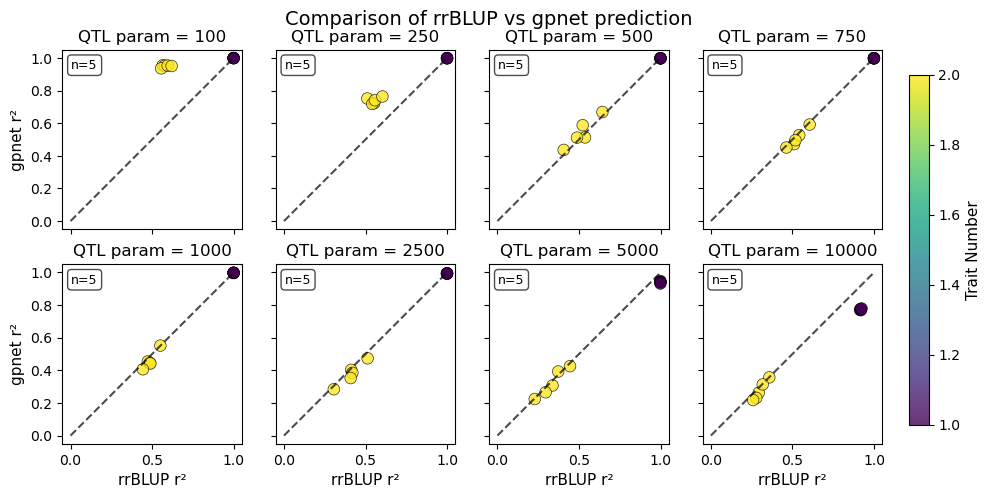

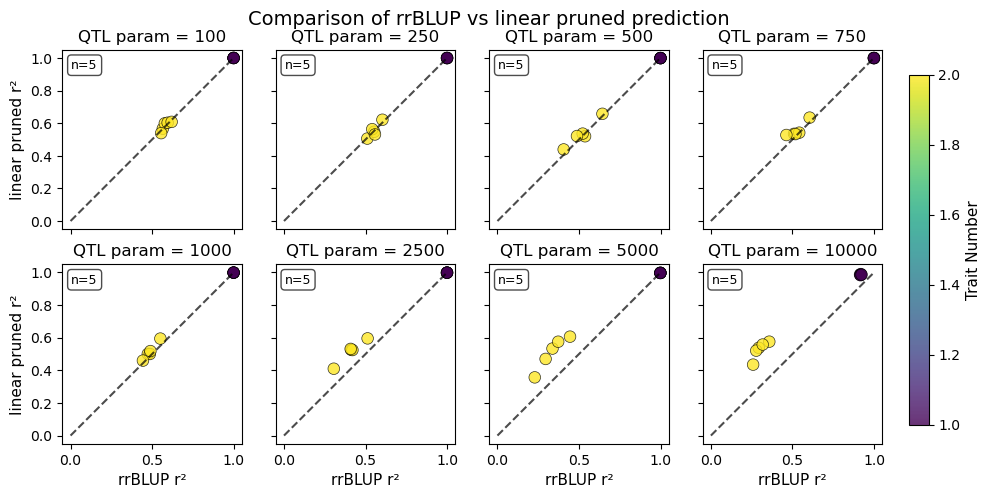

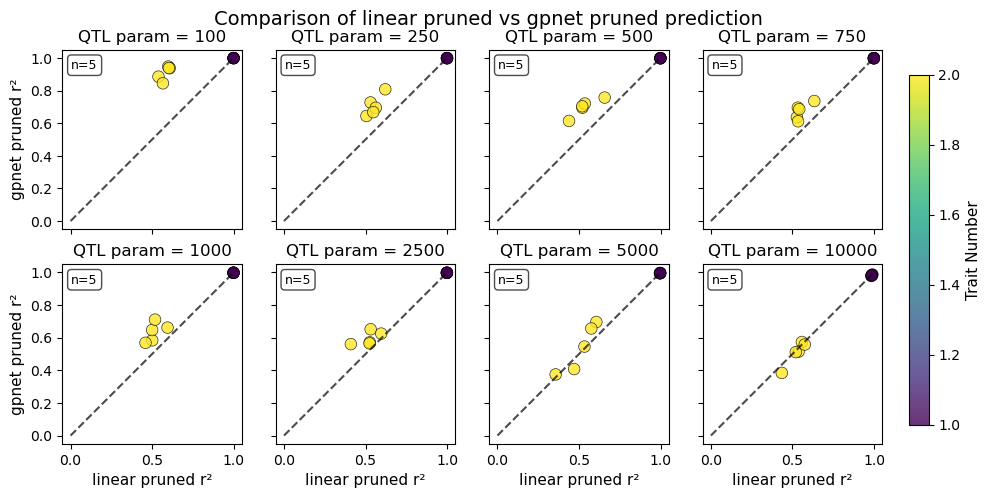

In [148]:
generate_comparison_plot(comparison_df, 'rrBLUP', 'gpnet')
generate_comparison_plot(comparison_df2, 'rrBLUP', 'linear pruned')
generate_comparison_plot(comparison_df3, 'linear pruned', 'gpnet pruned')
